In [31]:
from hydra.core.global_hydra import GlobalHydra
from hydra import initialize_config_dir, compose
import pandas as pd
from pathlib import Path
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Initialize Hydra with the config path
GlobalHydra.instance().clear()
initialize_config_dir(config_dir="/home/ta-tldr/Project/tldr/config/", version_base=None)
cfg = compose(config_name="AIVideoConf.yaml")
paperlist_root = cfg.AIConfVideo.paperlist_root
video_root = paperlist_root + "video/"

# per_token = True
per_token = False
post_fix = "_InternVL3-38B"

# load csv file
tldr_df_comp = pd.read_csv(Path(video_root, f"tldr_mutual_info_video_text{post_fix}.csv"))
tldr_df_info = pd.read_csv(Path(video_root, f"tldr_mutual_info_text_task{post_fix}.csv"))
abs_df_comp = pd.read_csv(Path(video_root, f"abstract_mutual_info_video_text{post_fix}.csv"))
abs_df_info = pd.read_csv(Path(video_root, f"abstract_mutual_info_text_task{post_fix}.csv"))
aware_df_comp = pd.read_csv(Path(video_root, f"aware_mutual_info_video_text{post_fix}.csv"))
aware_df_info = pd.read_csv(Path(video_root, f"aware_mutual_info_text_task{post_fix}.csv"))
agnostic_df_comp = pd.read_csv(Path(video_root, f"agnostic_mutual_info_video_text{post_fix}.csv"))
agnostic_df_info = pd.read_csv(Path(video_root, f"agnostic_mutual_info_text_task{post_fix}.csv"))
response0_df_comp = pd.read_csv(Path(video_root, f"response0_mutual_info_video_text{post_fix}.csv"))
response0_df_info = pd.read_csv(Path(video_root, f"response0_mutual_info_text_task{post_fix}.csv"))
response1_df_comp = pd.read_csv(Path(video_root, f"response1_mutual_info_video_text{post_fix}.csv"))
response1_df_info = pd.read_csv(Path(video_root, f"response1_mutual_info_text_task{post_fix}.csv"))
response2_df_comp = pd.read_csv(Path(video_root, f"response2_mutual_info_video_text{post_fix}.csv"))
response2_df_info = pd.read_csv(Path(video_root, f"response2_mutual_info_text_task{post_fix}.csv"))
CoT_df_comp = pd.read_csv(Path(video_root, f"CoT_mutual_info_video_text{post_fix}.csv"))
CoT_df_info = pd.read_csv(Path(video_root, f"CoT_mutual_info_text_task{post_fix}.csv"))

In [32]:
# Filter out rows with -10 in logprob_text or logprob
# filtered_rows = (tldr_df_info['logprob_text'] > -10) & (tldr_df_info['logprob'] > -10) & (abs_df_info['logprob_text'] > -10) & (abs_df_info['logprob'] > -10) & (aware_df_info['logprob_text'] > -10) & (aware_df_info['logprob'] > -10) & (agnostic_df_info['logprob_text'] > -10) & (agnostic_df_info['logprob'] > -10)
# filtered_rows = (tldr_df_info['logprob_text'] > -10) & (tldr_df_info['logprob'] > -10) & (abs_df_info['logprob_text'] > -10) & (abs_df_info['logprob'] > -10)
def filter_logprob(df_info, threshold=-10):
    return (df_info['logprob_text'] > threshold) & (df_info['logprob'] > threshold)

# Apply the function to each dataframe
filtered_rows = (
    filter_logprob(tldr_df_info) &
    filter_logprob(abs_df_info) &
    filter_logprob(aware_df_info) &
    filter_logprob(agnostic_df_info) &
    filter_logprob(response0_df_info) &
    filter_logprob(response1_df_info) &
    filter_logprob(response2_df_info)
    # filter_logprob(CoT_df_info)
)

print(len(tldr_df_info[filtered_rows]), len(abs_df_info[filtered_rows]))

# Filter out rows without videos
excluded_ids = ['pPh9p8anUi', 't7wvJstsiV', 'kXErlJSZ84', 'jJCeMiwHdH', 'kVr3L73pNH', 'S3HvA808gk', 'rvUq3cxpDF', 'oLLZhbBSOU', 'JjQl8hXJAS', 'gvlOQC6oP1', 'QgaGs7peYe']
filtered_rows &= ~tldr_df_info['openreview_id'].isin(excluded_ids)

tldr_df_info_filtered = tldr_df_info[filtered_rows]
abs_df_info_filtered = abs_df_info[filtered_rows]
aware_df_info_filtered = aware_df_info[filtered_rows]
agnostic_df_info_filtered = agnostic_df_info[filtered_rows]
CoT_df_info_filtered = CoT_df_info[filtered_rows]
response0_df_info_filtered = response0_df_info[filtered_rows]
response1_df_info_filtered = response1_df_info[filtered_rows]
response2_df_info_filtered = response2_df_info[filtered_rows]

def calculate_tldr_scores(df_info_filtered):
    log_info_scores = []
    info_ranks = []
    for openreview_id in df_info_filtered['openreview_id']:
        row = df_info_filtered[df_info_filtered['openreview_id'] == openreview_id]
        info_score = row['informativeness_score'].values[0]
        log_info_scores.append(info_score)
        info_ranks.append(row["logprob_text"].values[0] - row["logprob"].values[0])
    return log_info_scores, info_ranks

tldr_log_info_scores, tldr_info_ranks = calculate_tldr_scores(tldr_df_info_filtered)
abs_log_info_scores, abs_info_ranks = calculate_tldr_scores(abs_df_info_filtered)
aware_log_info_scores, aware_info_ranks = calculate_tldr_scores(aware_df_info_filtered)
agnostic_log_info_scores, agnostic_info_ranks = calculate_tldr_scores(agnostic_df_info_filtered)
CoT_log_info_scores, CoT_info_ranks = calculate_tldr_scores(CoT_df_info_filtered)
response0_log_info_scores, response0_info_ranks = calculate_tldr_scores(response0_df_info_filtered)
response1_log_info_scores, response1_info_ranks = calculate_tldr_scores(response1_df_info_filtered)
response2_log_info_scores, response2_info_ranks = calculate_tldr_scores(response2_df_info_filtered)

# print the min and max rows (openreview_id) of informativeness scores
tldr_min_informativeness = tldr_df_info_filtered[tldr_df_info_filtered['informativeness_score'] == min(tldr_log_info_scores)]
tldr_max_informativeness = tldr_df_info_filtered[tldr_df_info_filtered['informativeness_score'] == max(tldr_log_info_scores)]
abs_min_informativeness = abs_df_info_filtered[abs_df_info_filtered['informativeness_score'] == min(abs_log_info_scores)]
abs_max_informativeness = abs_df_info_filtered[abs_df_info_filtered['informativeness_score'] == max(abs_log_info_scores)]
print("TLDR min informativeness: ", tldr_min_informativeness['openreview_id'].values[0])
print("TLDR max informativeness: ", tldr_max_informativeness['openreview_id'].values[0])
print("Abstract min informativeness: ", abs_min_informativeness['openreview_id'].values[0])
print("Abstract max informativeness: ", abs_max_informativeness['openreview_id'].values[0])
print("Aware min informativeness: ", aware_df_info_filtered[aware_df_info_filtered['informativeness_score'] == min(aware_log_info_scores)]['openreview_id'].values[0])
print("Aware max informativeness: ", aware_df_info_filtered[aware_df_info_filtered['informativeness_score'] == max(aware_log_info_scores)]['openreview_id'].values[0])
print("Agnostic min informativeness: ", agnostic_df_info_filtered[agnostic_df_info_filtered['informativeness_score'] == min(agnostic_log_info_scores)]['openreview_id'].values[0])
print("Agnostic max informativeness: ", agnostic_df_info_filtered[agnostic_df_info_filtered['informativeness_score'] == max(agnostic_log_info_scores)]['openreview_id'].values[0])
print("CoT min informativeness: ", CoT_df_info_filtered[CoT_df_info_filtered['informativeness_score'] == min(CoT_log_info_scores)]['openreview_id'].values[0])
print("CoT max informativeness: ", CoT_df_info_filtered[CoT_df_info_filtered['informativeness_score'] == max(CoT_log_info_scores)]['openreview_id'].values[0])

87 87
TLDR min informativeness:  L9U5MJJleF
TLDR max informativeness:  5GCgNFZSyo
Abstract min informativeness:  ag7piyoyut
Abstract max informativeness:  lfY0SUT3m9
Aware min informativeness:  L9U5MJJleF
Aware max informativeness:  mQ72XRfYRZ
Agnostic min informativeness:  L9U5MJJleF
Agnostic max informativeness:  2UnCj3jeao
CoT min informativeness:  L3RYBqzRmF
CoT max informativeness:  lfY0SUT3m9


In [33]:
def initialize_dataframe():
    columns = ['openreview_id', 'predicted_word_video', 'predicted_word', 'orig_word', 'complexity_score', 'rank_video', 'rank']
    dtypes = {
        'openreview_id': 'str', 
        'predicted_word_video': 'object',
        'predicted_word': 'object',        
        'orig_word': 'object',             
        'complexity_score': 'float', 
        'rank_video': 'object',            
        'rank': 'object'                   
    }
    return pd.DataFrame(columns=columns).astype(dtypes)

def process_data(df_info_filtered, df_comp):
    df_comp_total = initialize_dataframe()
    log_comp_scores = []
    comp_ranks = []
    max_id, min_id = None, None
    max_diff, min_diff = -100, 100
    num_tokens = []
    
    for openreview_id in df_info_filtered['openreview_id'].unique():
        row = df_comp[df_comp['openreview_id'] == openreview_id]
        if per_token:
            diff_count = len(row)
        else:
            diff_count = 1  # Placeholder value
        diff = row['diff'].sum()
        if diff == 0:
            print(f"Diff is 0 for openreview_id: {openreview_id}. This might be due to no video.")
            # continue
        
        log_comp_scores.append(diff / diff_count)
        comp_ranks.append(row['logprob_video'].values[0] - row['logprob'].values[0])
        num_tokens.append(diff_count)
        
        if diff > max_diff:
            max_diff = diff
            max_id = openreview_id
        if diff < min_diff:
            min_diff = diff
            min_id = openreview_id
        
        new_row = pd.DataFrame({
            'openreview_id': [openreview_id], 
            'predicted_word_video': [row['predicted_word_video'].values], 
            'predicted_word': [row['predicted_word'].values], 
            'orig_word': [row['orig_word'].values], 
            'complexity_score': [diff / diff_count], 
            'rank_video': [row['rank_video'].values], 
            'rank': [row['rank'].values]
        })
        df_comp_total = pd.concat([df_comp_total, new_row], ignore_index=True)
    
    return df_comp_total, log_comp_scores, comp_ranks, max_id, min_id, num_tokens


# Process TLDR data
tldr_df_comp_total, tldr_log_comp_scores, tldr_comp_ranks, tldr_max_id, tldr_min_id, tldr_num_tokens = process_data(tldr_df_info_filtered, tldr_df_comp)
print(f"TLDR max complexity: {tldr_max_id}, TLDR min complexity: {tldr_min_id}")
print(f"Avg TLDR num of tokens: {sum(tldr_num_tokens) / len(tldr_num_tokens)}")
# Process Abstract data
abs_df_comp_total, abs_log_comp_scores, abs_comp_ranks, abs_max_id, abs_min_id, abs_num_tokens = process_data(abs_df_info_filtered, abs_df_comp)
print(f"Abstract max complexity: {abs_max_id}, Abstract min complexity: {abs_min_id}")
print(f"Avg Abstract num of tokens: {sum(abs_num_tokens) / len(abs_num_tokens)}")
# Process Aware data
aware_df_comp_total, aware_log_comp_scores, aware_comp_ranks, _, _, _ = process_data(aware_df_info_filtered, aware_df_comp)
# Process Agnostic data
agnostic_df_comp_total, agnostic_log_comp_scores, agnostic_comp_ranks, _, _, _ = process_data(agnostic_df_info_filtered, agnostic_df_comp)
# Process CoT data
CoT_df_comp_total, CoT_log_comp_scores, CoT_comp_ranks, _, _, _ = process_data(CoT_df_info_filtered, CoT_df_comp)
# Process Response0 data
response0_df_comp_total, response0_log_comp_scores, response0_comp_ranks, _, _, _ = process_data(response0_df_info_filtered, response0_df_comp)
# Process Response1 data
response1_df_comp_total, response1_log_comp_scores, response1_comp_ranks, _, _, _ = process_data(response1_df_info_filtered, response1_df_comp)
# Process Response2 data
response2_df_comp_total, response2_log_comp_scores, response2_comp_ranks, _, _, _ = process_data(response2_df_info_filtered, response2_df_comp)


TLDR max complexity: jCMYIUwprx, TLDR min complexity: zqLAMwVLkt
Avg TLDR num of tokens: 1.0
Abstract max complexity: duyA42HlCK, Abstract min complexity: 5sm8YDnWvC
Avg Abstract num of tokens: 1.0
Diff is 0 for openreview_id: aBmiyi7iA7. This might be due to no video.
Diff is 0 for openreview_id: XIaS66XkNA. This might be due to no video.
Diff is 0 for openreview_id: BifeBRhikU. This might be due to no video.
Diff is 0 for openreview_id: mY0ZnS2s9u. This might be due to no video.
Diff is 0 for openreview_id: wblxm5zdkE. This might be due to no video.
Diff is 0 for openreview_id: XIaS66XkNA. This might be due to no video.


In [34]:
# Add a 'group' column to each DataFrame before concatenation
aware_df_info_filtered = aware_df_info_filtered.copy().drop(columns=["predicted_answer_text", "predicted_answer"])
agnostic_df_info_filtered = agnostic_df_info_filtered.copy().drop(columns=["predicted_answer_text", "predicted_answer"])
response0_df_info_filtered = response0_df_info_filtered.copy().drop(columns=["predicted_answer_text", "predicted_answer"])
response1_df_info_filtered = response1_df_info_filtered.copy().drop(columns=["predicted_answer_text", "predicted_answer"])
response2_df_info_filtered = response2_df_info_filtered.copy().drop(columns=["predicted_answer_text", "predicted_answer"])

aware_df_info_filtered.loc[:, 'group'] = 'aware'
agnostic_df_info_filtered.loc[:, 'group'] = 'agnostic'
response0_df_info_filtered.loc[:, 'group'] = 'response0'
response1_df_info_filtered.loc[:, 'group'] = 'response1'
response2_df_info_filtered.loc[:, 'group'] = 'response2'

# Then concatenate as before
merged_info_df = pd.concat([aware_df_info_filtered, agnostic_df_info_filtered, response0_df_info_filtered, response1_df_info_filtered, response2_df_info_filtered], ignore_index=True)
# Sort the merged DataFrame by 'openreview_id'
merged_info_df = merged_info_df.sort_values(by=['openreview_id', 'group'])
print(f"merged_info_df shape: {merged_info_df.shape}")

# Group by openreview_id and pick the row with the maximum informativeness_score
max_informativeness_df = merged_info_df.sort_values('informativeness_score', ascending=False).drop_duplicates('openreview_id').reset_index(drop=True)
print(f"max_informativeness_df shape: {max_informativeness_df.shape}")

merged_info_df.head(10)

merged_info_df shape: (435, 9)
max_informativeness_df shape: (87, 9)


,video_id,openreview_id,correct_answer,informativeness_score,logprob_text,logprob,rank_text,rank,group
101,39025188,2NfBBpbN9x,B,-1.339515,-4.373467,-3.033953,9,5,agnostic
14,39025188,2NfBBpbN9x,B,-2.544307,-5.578259,-3.033953,10,5,aware
188,39025188,2NfBBpbN9x,B,2.318897,-0.715056,-3.033953,1,5,response0
275,39025188,2NfBBpbN9x,B,2.181197,-0.852756,-3.033953,1,5,response1
362,39025188,2NfBBpbN9x,B,2.306458,-0.727495,-3.033953,1,5,response2
119,39025418,2RS0fL7Eet,J,-1.799126,-1.886928,-0.087802,3,1,agnostic
32,39025418,2RS0fL7Eet,J,-1.734152,-1.821954,-0.087802,3,1,aware
206,39025418,2RS0fL7Eet,J,-0.091596,-0.179398,-0.087802,1,1,response0
293,39025418,2RS0fL7Eet,J,-0.230135,-0.331491,-0.101356,1,1,response1
380,39025418,2RS0fL7Eet,J,-0.112090,-0.200970,-0.088881,1,1,response2


In [35]:
# add a 'group' column to each dataframe
aware_df_comp_total.loc[:, 'group'] = 'aware'
agnostic_df_comp_total.loc[:, 'group'] = 'agnostic'
response0_df_comp_total.loc[:, 'group'] = 'response0'
response1_df_comp_total.loc[:, 'group'] = 'response1'
response2_df_comp_total.loc[:, 'group'] = 'response2'

# then concatenate as before
merged_complexity_df = pd.concat([aware_df_comp_total, agnostic_df_comp_total, response0_df_comp_total, response1_df_comp_total, response2_df_comp_total], ignore_index=True)
merged_complexity_df = merged_complexity_df.sort_values(by=['openreview_id', 'group'])
print(f"merged_complexity_df shape: {merged_complexity_df.shape}")

# Group by openreview_id and pick the row with the minimum complexity_score
min_complexity_df = merged_complexity_df.sort_values('complexity_score', ascending=True).drop_duplicates('openreview_id').reset_index(drop=True)
print(f"min_complexity_df shape: {min_complexity_df.shape}")
merged_complexity_df.head(10)

merged_complexity_df shape: (435, 8)
min_complexity_df shape: (87, 8)


,openreview_id,predicted_word_video,predicted_word,orig_word,complexity_score,rank_video,rank,group
101,2NfBBpbN9x,"[presentation, image, diff, gener, model, time...","[presentation, image, diffusion, gener, model,...","[presentation, image, diffusion, generative, m...",27.310557,"[11, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1]","[-1, 9, -1, 1, 3, 2, 1, 2, 2, 1, 3, 1, 1]",agnostic
14,2NfBBpbN9x,"[image, diff, gener, model, time, series, long...","[image, diffusion, gener, model, time, series,...","[image, diffusion, generative, modeling, time,...",27.920480,"[1, 1, 1, 1, 1, 1, 1, -1, -1]","[-1, -1, 12, 3, 1, 1, 1, -1, -1]",aware
188,2NfBBpbN9x,"[time, series, util, diff, image, super, long,...","[time, series, util, diffusion, image, super, ...","[time, series, utilizing, diffusion, image, su...",34.626485,"[1, 1, 2, 1, 1, 2, 1, 1, 2]","[4, 1, 16, -1, -1, 1, 2, 1, 13]",response0
275,2NfBBpbN9x,"[time, series, util, diff, image, super]","[time, series, util, diffusion, image, super]","[time, series, utilizing, diffusion, image, su...",34.226978,"[1, 1, 2, 1, 1, 1]","[-1, 1, 17, -1, -1, 1]",response1
362,2NfBBpbN9x,"[integrates, image, diff, create, scal, enabli...","[integrates, image, diffusion, create, scal, e...","[integrates, image, diffusion, create, scalabl...",33.111614,"[-1, 1, 1, 1, 2, -1, 1, 1, 1, 1, 1]","[-1, 9, -1, 2, 10, -1, 1, 7, 6, -1, 1]",response2
119,2RS0fL7Eet,"[p, st, optim, al, instrument, variable, reg, ...","[p, stochastic, optim, al, instrumental, varia...","[presents, stochastic, optimization, algorithm...",50.919111,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, ...","[3, -1, 4, 1, -1, 2, 2, 1, 2, -1, -1, 2, 18, 1...",agnostic
32,2RS0fL7Eet,"[p, st, optim, al, instrument, variable, reg, ...","[p, stochastic, optim, al, instrumental, varia...","[presents, stochastic, optimization, algorithm...",36.663611,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[3, -1, 5, 1, -1, 2, 4, 1, 6, 1, 14, 1, 1]",aware
206,2RS0fL7Eet,"[st, optim, al, instrument, variable, reg, add...","[stochastic, optim, al, instrumental, variable...","[stochastic, optimization, algorithms, instrum...",33.148548,"[1, 1, 1, 1, 1, 1, 4, 1, 1, 1, -1, 1, 2, 2, 1, 1]","[-1, 5, 1, -1, 6, 5, 3, 11, 1, 1, 12, 7, 1, 1,...",response0
293,2RS0fL7Eet,"[St, instrumental, variable, regression, focus...","[St, Instrument, variable, regression, focusin...","[stochastic, instrumental, variable, regressio...",-6.273348,"[13, -1, -1, -1, -1, -1, -1, -1, -1, -1]","[20, 3, -1, -1, -1, -1, -1, -1, -1, -1]",response1
380,2RS0fL7Eet,"[St, instrumental, variable, regression, addre...","[stochastic, instrumental, variable, regressio...","[stochastic, instrumental, variable, regressio...",8.022072,"[17, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1]","[-1, -1, 9, -1, -1, -1, -1, -1, -1, -1, -1]",response2


In [36]:
# merge the rows of the two dataframes with the same record_id and group
ib_df = pd.merge(merged_complexity_df, merged_info_df, on=['openreview_id', 'group'], how='inner')
ib_df = ib_df.sort_values(['openreview_id', 'group'], ascending=True)

parameter_search_type = "convex_combination"
num_steps = 21
if parameter_search_type == "convex_combination":
    # Convex Combination Grid
    alpha_betas = [(round(a, 3), round(1 - a, 3)) for a in np.linspace(0, 1, num_steps)]
elif parameter_search_type == "unit_norm":
    # Unit Norm Grid 
    angles = np.linspace(0, np.pi/2, num_steps)
    alpha_betas = [(round(np.cos(t), 3), round(np.sin(t), 3)) for t in angles]
print(alpha_betas)

max_ib_dfs = []
max_ib_labels = []
for idx, ab in enumerate(alpha_betas):
    a, b = ab
    max_ib_labels.append(f'Max IB ($\\alpha,\\beta=({a},{b})$)')
    ib_df[f'ib_score_beta_{ab}'] = a * ib_df['complexity_score'] + b * ib_df['informativeness_score']
    # ascending=False to get the max score
    max_ib_dfs.append(ib_df.sort_values(f'ib_score_beta_{ab}', ascending=False).drop_duplicates('openreview_id').reset_index(drop=True))
    ib_df.drop(columns=[f'ib_score_beta_{ab}'], inplace=True)
# print(max_ib_dfs[-1].shape)
# print(max_ib_dfs[-1].head())

# randomly sample ib scores
np.random.seed(42)
ib_df["random_score"] = np.random.randint(0, 1000, len(ib_df))
# ascending=False to get the max score
max_ib_dfs.append(ib_df.sort_values('random_score', ascending=False).drop_duplicates('openreview_id').reset_index(drop=True))
ib_df.drop(columns=['random_score'], inplace=True)
# print(max_ib_dfs[-1].shape)
# print(max_ib_dfs[-1].head())

random_df = max_ib_dfs[-1]

[(0.0, 1.0), (0.05, 0.95), (0.1, 0.9), (0.15, 0.85), (0.2, 0.8), (0.25, 0.75), (0.3, 0.7), (0.35, 0.65), (0.4, 0.6), (0.45, 0.55), (0.5, 0.5), (0.55, 0.45), (0.6, 0.4), (0.65, 0.35), (0.7, 0.3), (0.75, 0.25), (0.8, 0.2), (0.85, 0.15), (0.9, 0.1), (0.95, 0.05), (1.0, 0.0)]


In [37]:
import shutil

def set_plot_properties(
    font_size: float = 20,
    legend_font_size: float = 14,
    xtick_label_size: float = 14,
    ytick_label_size: float = 14,
    markersize: float = 10,
    usetex: bool = True,
    autolayout=True,
) -> None:
    """Sets plot properties.

    :param font_size: font size
    :param legend_font_size: legend font size
    :param xtick_label_size: xtick label size
    :param ytick_label_size: ytick label size
    :param markersize: marker size
    :param usetex: use tex
    :return: None.
    """
    sns.set_color_codes()
    sns.set()

    if shutil.which("latex"):
        plt.rc("text", usetex=usetex)
    else:
        plt.rc("text", usetex=False)
    font = {"family": "normal", "weight": "bold", "size": font_size}
    plt.rc("font", **font)
    plt.rcParams["text.latex.preamble"] = r"\boldmath"

    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["font.weight"] = "bold"

    params = {
        "legend.fontsize": legend_font_size,
        "axes.labelsize": font_size,
        "axes.titlesize": font_size,
        "xtick.labelsize": xtick_label_size,
        "ytick.labelsize": ytick_label_size,
        "lines.markersize": markersize,
        "figure.autolayout": autolayout,
    }

    plt.rcParams.update(params)

    # Use ticks style but only keep bottom and left spines
    sns.set_style("ticks")
    plt.rc('axes', edgecolor='black')
    plt.rc('axes.spines', right=False, top=False, left=True, bottom=True)

set_plot_properties(font_size=12, legend_font_size=12, xtick_label_size=12, ytick_label_size=12, markersize=10)


In [38]:
visible = {
    'TLDR': True,
    'Abstract': True,
    'Naive VLM': True,
    'VLM (Agnostic)': True,
    'CoT': True
}
for label in max_ib_labels:
    visible[label] = True

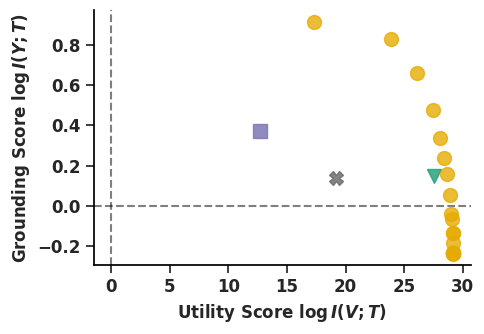

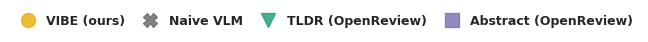

In [39]:
# Create a figure for the scatter plot only
fig = plt.figure(figsize=(5, 3.5))
scatter_ax = fig.add_subplot(111)  # Single plot taking up the entire figure

# Create a simplified color palette with only needed colors
colors = sns.color_palette("Dark2")  # Only need 4 colors
markers = ['v', 's', 'X', 'o', 'D']
opacity = 0.8

# Define data groups - only keeping the ones that are used
data_groups = {
    'TLDR': {
        'x': tldr_log_comp_scores,
        'y': tldr_log_info_scores,
        'color': colors[0],
        'marker': markers[0],
        'alpha': opacity
    },
    'Abstract': {
        'x': abs_log_comp_scores,
        'y': abs_log_info_scores,
        'color': colors[2],
        'marker': markers[1],
        'alpha': opacity
    },
    'Naive VLM': {
        'x': random_df['complexity_score'],
        'y': random_df['informativeness_score'],
        'color': colors[7],
        'marker': markers[2],
        'alpha': opacity
    },
    # 'CoT': {
    #     'x': CoT_log_comp_scores,
    #     'y': CoT_log_info_scores,
    #     'color': colors[1],
    #     'marker': markers[4],
    #     'alpha': opacity
    # },
}
for idx, label in enumerate(max_ib_labels):
    data_groups[label] = {
        'x': max_ib_dfs[idx]['complexity_score'],
        'y': max_ib_dfs[idx]['informativeness_score'],
        'color': colors[5],
        'marker': markers[3],
        'alpha': opacity
    }

# Create scatter plots for each group
ib_legend = False
legend_handles = []
legend_labels = []

for label, group_data in data_groups.items():
    if label == 'CoT':
        label_latex = "VLM (CoT)"
    elif label == 'VLM (Agnostic)':
        label_latex = 'VLM (Agnostic)'
    elif label == 'Naive VLM':
        label_latex = 'Naive VLM'
    elif label in ['TLDR', 'Abstract']:
        label_latex = label + " (OpenReview)"
    elif "Max IB" in label and not ib_legend:
        # Create a more readable IB legend entry
        label_latex = "VIBE (ours)"
        ib_legend = True
    else:
        label_latex = ""
    
    # Error bars with standard deviation
    if visible[label]:
        handle = scatter_ax.errorbar(
            np.mean(group_data['x']), np.mean(group_data['y']),
            # xerr=np.std(group_data['x']), yerr=np.std(group_data['y']),
            fmt=group_data['marker'], color=group_data['color'], 
            elinewidth=1.5, capsize=8, alpha=group_data['alpha'],
            markersize=10  # Increased marker size
        )
        if label_latex:  # Only add to legend if we have a label
            legend_handles.append(handle)
            legend_labels.append(label_latex)

# Add x=0 and y=0 lines
scatter_ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.set_xlabel('Utility Score $\log I(V;T)$ ') # negative complexity score
scatter_ax.set_ylabel('Grounding Score $\log I(Y;T)$ ') # informativeness score
# scatter_ax.set_xlim(0, 35)
# scatter_ax.set_ylim(-0.5, 2)

# Create a separate figure just for the legend
# NeurIPS template width is 5.5in, so we set the figure width to exactly match that
legend_fig = plt.figure(figsize=(5.5, 0.5))
legend_ax = legend_fig.add_subplot(111)
legend_ax.axis('off')  # Hide the axes

# Reorder legend entries to a specific order
# Create new ordered lists for handles and labels
ordered_indices = []
desired_order = ["VIBE (ours)", "Naive VLM", "TLDR (OpenReview)", "Abstract (OpenReview)"]
for label in desired_order:
    if label in legend_labels:
        ordered_indices.append(legend_labels.index(label))

ordered_handles = [legend_handles[i] for i in ordered_indices]
ordered_labels = [legend_labels[i] for i in ordered_indices]

# Add the legend to the new figure with reordered entries
legend = legend_ax.legend(
    handles=ordered_handles,
    labels=ordered_labels,
    frameon=False,
    ncol=len(ordered_handles),
    fontsize=9,
    loc='center',
    columnspacing=1.0,
    handletextpad=0.5,
    bbox_to_anchor=(0.5, 0.5),
    bbox_transform=legend_fig.transFigure
)

# Ensure the figure is exactly 5.5 inches wide to match NeurIPS template
legend_fig.set_size_inches(5.5, 0.5, forward=True)
plt.tight_layout()
plt.show()

# Save the main figure to a high-resolution PDF
fig.savefig('internvl3.pdf', format='pdf', dpi=300, bbox_inches='tight')

KeyError: 'VLM (Aware)'

/home/ta-tldr/miniconda3/envs/tldr/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/ta-tldr/miniconda3/envs/tldr/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


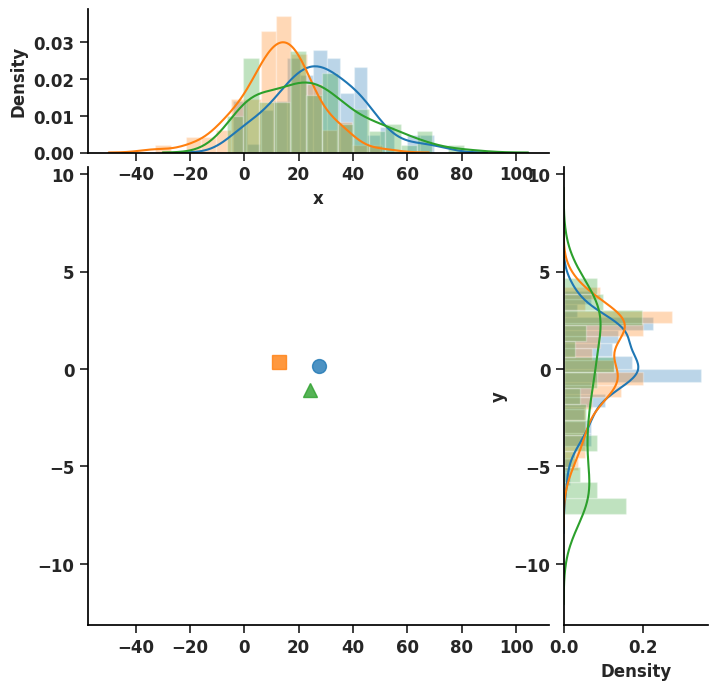

In [40]:
# Create a grid layout with space for histograms
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.1, hspace=0.1)
scatter_ax = fig.add_subplot(gs[1:4, 0:3])  # Main scatter plot
x_hist_ax = fig.add_subplot(gs[0, 0:3], sharex=scatter_ax)  # X-axis histograms
y_hist_ax = fig.add_subplot(gs[1:4, 3], sharey=scatter_ax)  # Y-axis histograms

# Create a custom color palette for better distinction
# Sample a total of 6 colors, markers, and opacity values
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#d62728', '#e377c2', '#7f7f7f']
markers = ['o', 's', '^', 'd', 'x', 'P', '*', '+']
opacity = [0.8, 0.8, 0.8, 0.8, 1, 1, 1, 1]

# Define data groups
data_groups = {
    'TLDR': {
        'x': tldr_log_comp_scores,
        'y': tldr_log_info_scores,
        'color': colors[0],
        'marker': markers[0],
        'alpha': opacity[0]
    },
    'Abstract': {
        'x': abs_log_comp_scores,
        'y': abs_log_info_scores,
        'color': colors[1],
        'marker': markers[1],
        'alpha': opacity[1]
    },
    'CoT': {
        'x': CoT_log_comp_scores,
        'y': CoT_log_info_scores,
        'color': colors[2],
        'marker': markers[2],
        'alpha': opacity[2]
    },
    'VLM (Aware)': {
        'x': aware_log_comp_scores,
        'y': aware_log_info_scores,
        'color': colors[3],
        'marker': markers[3],
        'alpha': opacity[3]
    },
    'VLM (Agnostic)': {
        'x': agnostic_log_comp_scores,
        'y': agnostic_log_info_scores,
        'color': colors[4],
        'marker': markers[4],
        'alpha': opacity[4]
    },
}
for idx, label in enumerate(max_ib_labels):
    data_groups[label] = {
        'x': max_ib_dfs[idx]['complexity_score'],
        'y': max_ib_dfs[idx]['informativeness_score'],
        'color': colors[6],
        'marker': markers[6],
        'alpha': opacity[6]
    }

# Create scatter plots and histograms for each group
ib_legend = False
for label, group_data in data_groups.items():
    if label == 'CoT':
        label_latex = "VLM (CoT)"
    elif label in ['VLM (Agnostic)', 'VLM (Aware)']:
        label_latex = label
    elif label in ['TLDR', 'Abstract']:
        label_latex = label + " (OpenReview)"
    elif "Max IB" in label and not ib_legend:
        label_latex = "IB, $(\\alpha, \\beta)$=["
        for idx, ab in enumerate(alpha_betas):
            label_latex += f"{ab},"
            if idx % 4 == 3:
                label_latex += '\n'
        label_latex += "] (ours)"
        ib_legend = True
    else:
        label_latex = ""

    # Main scatter plot
    # scatter_ax.scatter(
    #     group_data['x'], group_data['y'], 
    #     color=group_data['color'], marker=group_data['marker'], 
    #     label=label, alpha=group_data['alpha']
    # ) if visible[label] else None
    
    # Error bars with standard deviation
    scatter_ax.errorbar(
        np.mean(group_data['x']), np.mean(group_data['y']),
        # xerr=np.std(group_data['x']), yerr=np.std(group_data['y']),
        fmt=group_data['marker'], color=group_data['color'], 
        elinewidth=1.5, capsize=8, alpha=group_data['alpha'], label=label_latex,
        markersize=10  # Increased marker size
    ) if visible[label] else None
    
    # Histograms
    if visible[label] and label in ['TLDR', 'Abstract', 'CoT', 'Max IB ($\\beta=0.3$)', 'VLM (Agnostic)', 'VLM (Aware)']:
        # For x-axis histogram
        x_hist_ax.hist(group_data['x'], bins=15, alpha=0.3, color=group_data['color'], density=True)
        sns.kdeplot(
            data=group_data,
            x = 'x',
            ax=x_hist_ax,
            color=group_data['color'],
            alpha=1
        )
        
        # For y-axis histogram
        y_hist_ax.hist(group_data['y'], bins=15, orientation='horizontal', alpha=0.3, color=group_data['color'], density=True)
        sns.kdeplot(
            data=group_data,
            y = 'y',
            ax=y_hist_ax,
            color=group_data['color'],
            alpha=1
        )

# Add x=0 and y=0 lines
scatter_ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.set_xlabel('Utility Score $\log I(V;T)$ ') # negative complexity score
scatter_ax.set_ylabel('Grounding Score $\log I(Y;T)$ ') # informativeness score
scatter_ax.set_title('Utility vs Grounding', pad=120)
scatter_ax.set_xlim(0, 35)
scatter_ax.set_ylim(-5, 4)
# scatter_ax.invert_xaxis()

# Add a vertical arrow pointing upwards with text above it
scatter_ax.annotate('More\nInformative',
                    xy=(3.5, 3.75),  # Arrow tip
                    xytext=(3.5, 1.5),  # Arrow tail (lower position for upward direction)
                    arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                    fontsize=10, color='red',
                    ha='center',  # Center text horizontally
                    va='bottom')  # Ensure text is above the arrow

# # Add a horizontal arrow pointing left with text above it
# scatter_ax.annotate('Better Compression',
#                     xy=(2, 3),  # Arrow tip (further left)
#                     xytext=(15, 3),  # Arrow tail (even further left)
#                     arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
#                     fontsize=10, color='red',
#                     ha='center',  # Align text to the right (places it left of the arrow)
#                     va='center')  # Vertically center the text
# Add a horizontal arrow pointing left with text above it
scatter_ax.annotate('More Grounded to Video',
                    xy=(30, 3.5),  # Arrow tip (further left)
                    xytext=(15, 3.5),  # Arrow tail (even further left)
                    arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                    fontsize=10, color='red',
                    ha='center',  # Align text to the right (places it left of the arrow)
                    va='center')  # Vertically center the text


# Turn off axes for histograms
x_hist_ax.axis('off')
y_hist_ax.axis('off')

# Add legend
scatter_ax.legend(frameon=True, framealpha=0.9, loc='lower left')

plt.show()

### Length vs. Informativeness

In [ ]:
# load response length data
length_df = pd.read_csv(Path(paperlist_root, "dataset", "vlm_response_length.csv")) #.drop(columns=["response"])
length_df = length_df[length_df['openreview_id'].isin(tldr_df_info_filtered['openreview_id'])]

tldr_length = length_df[length_df['group'] == 'tldr']
abs_length = length_df[length_df['group'] == 'abstract']
CoT_length = length_df[length_df['group'] == 'CoT']
aware_length = length_df[length_df['group'] == 'aware']
agnostic_length = length_df[length_df['group'] == 'agnostic']
# IB filtering
length_df = length_df[length_df["group"].isin(["response0", "response1", "response2", "aware", "agnostic"])]
length_ib_dfs = []
for idx, ab in enumerate(alpha_betas):
    length_df = pd.merge(length_df, max_ib_dfs[idx][['openreview_id', f'ib_score_beta_{ab}']], on='openreview_id', how='inner')
    length_ib_dfs.append(length_df.sort_values(f'ib_score_beta_{ab}', ascending=False).drop_duplicates('openreview_id').reset_index(drop=True))
    length_df.drop(columns=[f'ib_score_beta_{ab}'], inplace=True)

print(length_df.sort_values(by='openreview_id').head(10))

In [ ]:
# save the best responses of each openreview ID according to the following criteria:
# 1. max informativeness score
# 2. max complexity score
# 3. min informativeness score
# 4. min complexity score


# Save the best responses based on the criteria
best_responses = {}

# 1. Max informativeness score
best_responses['max_informativeness'] = merged_info_df.loc[
    merged_info_df.groupby('openreview_id')['informativeness_score'].idxmax()
].drop(columns=['correct_answer', 'logprob_text', 'logprob', 'rank_text', 'rank'])

# 2. Max complexity score
best_responses['max_complexity'] = merged_complexity_df.loc[
    merged_complexity_df.groupby('openreview_id')['complexity_score'].idxmax()
].drop(columns=['predicted_word_video', 'predicted_word', 'orig_word', 'rank_video', 'rank'])

# 3. Min informativeness score
best_responses['min_informativeness'] = merged_info_df.loc[
    merged_info_df.groupby('openreview_id')['informativeness_score'].idxmin()
].drop(columns=['correct_answer', 'logprob_text', 'logprob', 'rank_text', 'rank'])

# 4. Min complexity score
best_responses['min_complexity'] = merged_complexity_df.loc[
    merged_complexity_df.groupby('openreview_id')['complexity_score'].idxmin()
].drop(columns=['predicted_word_video', 'predicted_word', 'orig_word', 'rank_video', 'rank'])

print("Best responses based on criteria:")
print("Max Informativeness:\n", best_responses["max_informativeness"].head())
print("Max Complexity:\n", best_responses["max_complexity"].head())
print("Min Informativeness:\n", best_responses["min_informativeness"].head())
print("Min Complexity:\n", best_responses["min_complexity"].head())

In [ ]:
# Add the parent directory to sys.path to make utils module accessible
import sys
sys.path.append(str(Path.cwd().parent.parent))
from utils.primary_area import subarea_map
OPTIONS = sorted(list(set(subarea_map.values())))

# save all the responses from best_responses
id2_responses_json = {}
for idx, row in length_df.iterrows():
    openreview_id = row['openreview_id']
    video_id = row['video_id']
    if openreview_id not in id2_responses_json:
        id2_responses_json[openreview_id] = {}
    for key, best_df in best_responses.items():
        group = best_df[best_df['openreview_id'] == openreview_id]['group'].values[0]
        id2_responses_json[openreview_id][key] = length_df[
            (length_df['openreview_id'] == openreview_id) & 
            (length_df['group'] == group)
        ]["response"].values[0]
    correct_option =  merged_info_df[
        merged_info_df['openreview_id'] == openreview_id
    ]["correct_answer"].values[0]
    correct_number = ord(correct_option) - ord('A')
    id2_responses_json[openreview_id]["correct_answer"] = OPTIONS[correct_number]
    id2_responses_json[openreview_id]['video_id'] = video_id

# save the json file
with open(Path(video_root, "best_responses.json"), 'w') as f:
    json.dump(id2_responses_json, f, indent=4)

In [ ]:
# Define data groups
data_groups_length = {
    'TLDR': {
        'x': tldr_length["length"],
        'y': tldr_log_info_scores,
        'color': colors[0],
        'marker': markers[0],
        'alpha': opacity[0]
    },
    'Abstract': {
        'x': abs_length["length"],
        'y': abs_log_info_scores,
        'color': colors[1],
        'marker': markers[1],
        'alpha': opacity[1]
    },
    'CoT': {
        'x': CoT_length["length"],
        'y': CoT_log_info_scores,
        'color': colors[2],
        'marker': markers[2],
        'alpha': opacity[2]
    },
    'VLM (Aware)': {
        'x': aware_length["length"],
        'y': aware_log_info_scores,
        'color': colors[3],
        'marker': markers[3],
        'alpha': opacity[3]
    },
    'VLM (Agnostic)': {
        'x': agnostic_length["length"],
        'y': agnostic_log_info_scores,
        'color': colors[4],
        'marker': markers[4],
        'alpha': opacity[4]
    },
}
for idx, label in enumerate(max_ib_labels):
    data_groups_length[label] = {
        'x': length_ib_dfs[idx]['length'],
        'y': max_ib_dfs[idx]['informativeness_score'],
        'color': colors[6],
        'marker': markers[6],
        'alpha': opacity[6]
    }

# Create a grid layout with space for histograms
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig, wspace=0.1, hspace=0.1)
scatter_ax = fig.add_subplot(gs[1:4, 0:3])  # Main scatter plot
x_hist_ax = fig.add_subplot(gs[0, 0:3], sharex=scatter_ax)  # X-axis histograms
y_hist_ax = fig.add_subplot(gs[1:4, 3], sharey=scatter_ax)  # Y-axis histograms

ib_legend = False
for label, group_data in data_groups_length.items():
    if label == 'CoT':
        label_latex = "VLM (CoT)"
    elif label in ['VLM (Agnostic)', 'VLM (Aware)']:
        label_latex = label
    elif label in ['TLDR', 'Abstract']:
        label_latex = label + " (OpenReview)"
    elif "Max IB" in label and not ib_legend:
        label_latex = "IB, $(\\alpha, \\beta)$=["
        for idx, ab in enumerate(alpha_betas):
            label_latex += f"{ab},"
            if idx % 4 == 3:
                label_latex += '\n'
        label_latex += "] (ours)"
        ib_legend = True
    else:
        label_latex = ""

    # Main scatter plot
    # scatter_ax.scatter(
    #     group_data['x'], group_data['y'],
    #     color=group_data['color'], marker=group_data['marker'],
    #     label=label, alpha=group_data['alpha']
    # ) if visible[label] else None

    # Error bars with standard deviation
    scatter_ax.errorbar(
        np.mean(group_data['x']), np.mean(group_data['y']),
        # xerr=np.std(group_data['x']), yerr=np.std(group_data['y']),
        fmt=group_data['marker'], color=group_data['color'],
        elinewidth=1.5, capsize=8, alpha=group_data['alpha'], label=label_latex,
        markersize=10  # Increased marker size
    ) if visible[label] else None
    # Histograms
    if visible[label] and label in ['TLDR', 'Abstract', 'CoT', 'Max IB ($\\beta=0.3$)', 'VLM (Agnostic)', 'VLM (Aware)']:
        # For x-axis histogram
        x_hist_ax.hist(group_data['x'], bins=15, alpha=0.3, color=group_data['color'], density=True)
        sns.kdeplot(
            data=group_data,
            x = 'x',
            ax=x_hist_ax,
            color=group_data['color'],
            alpha=1
        )
        
        # For y-axis histogram
        y_hist_ax.hist(group_data['y'], bins=15, orientation='horizontal', alpha=0.3, color=group_data['color'], density=True)
        sns.kdeplot(
            data=group_data,
            y = 'y',
            ax=y_hist_ax,
            color=group_data['color'],
            alpha=1
        )

# Add x=0 and y=0 lines
scatter_ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.set_xlabel('Number of Tokens')
scatter_ax.set_ylabel('Utility Score')
scatter_ax.set_title('Utility vs. Length of Captions', pad=120)
scatter_ax.set_xlim(0, 300)
scatter_ax.set_ylim(-5, 4)
# scatter_ax.invert_xaxis()
# Add a vertical arrow pointing upwards with text above it
scatter_ax.annotate('More\nInformative',
                    xy=(265, 3.5),  # Arrow tip
                    xytext=(265, 1.2),  # Arrow tail (lower position for upward direction)
                    arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                    fontsize=10, color='red',
                    ha='center',  # Center text horizontally
                    va='bottom')  # Ensure text is above the arrow
# Add a horizontal arrow pointing left with text above it
scatter_ax.annotate('Shorter Response',
                    xy=(50, 3.5),  # Arrow tip (left)
                    xytext=(125, 3.5),  # Arrow tail (right)
                    arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                    fontsize=10, color='red',
                    ha='center',  # Align text to the right (places it left of the arrow)
                    va='center')  # Vertically center the text
# Turn off axes for histograms
x_hist_ax.axis('off')
y_hist_ax.axis('off')
# Add legend
scatter_ax.legend(frameon=True, framealpha=0.9, loc='lower left')
plt.show()

### Correlation

In [ ]:
# calculate the correlation coefficient for each group
print("Correlation coefficients between length and informativeness score:")
for label, group_data in data_groups_length.items():
    correlation = np.corrcoef(group_data['x'], group_data['y'])[0, 1]
    print(f"{label}: Correlation coefficient: {correlation:.2f}")

In [ ]:
print("Correlation coefficients between length and complexity score:")
for label, group_data in data_groups_length.items():
    length = group_data['x']
    complexity = data_groups[label]['x']
    correlation = np.corrcoef(length, complexity)[0, 1]
    print(f"{label}: Correlation coefficient: {correlation:.2f}")

In [ ]:
print("Correlation coefficients between informativeness and complexity score:")
for label, group_data in data_groups.items():
    correlation = np.corrcoef(group_data['x'], group_data['y'])[0, 1]
    print(f"{label}: Correlation coefficient: {correlation:.2f}")

### Stat Test

In [ ]:
from pingouin import multivariate_ttest
from itertools import combinations
import numpy as np

score_dict = {}
if visible['TLDR']:
    score_dict['TLDR'] = np.array([tldr_log_comp_scores, tldr_log_info_scores]).transpose()
if visible['Abstract']:
    score_dict['Abstract'] = np.array([abs_log_comp_scores, abs_log_info_scores]).transpose()
for idx, label in enumerate(max_ib_labels):
    if visible[label]:
        score_dict[label] = np.array([max_ib_dfs[idx]['complexity_score'], max_ib_dfs[idx]['informativeness_score']]).transpose()
if visible['CoT']:
    score_dict['CoT'] = np.array([CoT_log_comp_scores, CoT_log_info_scores]).transpose()

# Conduct Hotelling's T² tests for all possible two-entry combinations
for (name1, scores1), (name2, scores2) in combinations(score_dict.items(), 2):
    t_result = multivariate_ttest(scores1, scores2)
    print(f"\n=== Hotelling's T² test: {name1} vs {name2} ===")
    print(f"{'* ' if t_result['pval'].iloc[0] < 0.05 else ''}T² statistic: {t_result['T2'].iloc[0]:.4f}, F-value: {t_result['F'].iloc[0]:.4f}, p-value: {t_result['pval'].iloc[0]}")


In [ ]:
# p-value test for raw and max informativeness
print("\n=== Informativeness T-Test ===")
t_result = ttest_ind(aware_log_info_scores, informativeness_score_by_maxinfo)
print(f"{'*' if t_result.pvalue < 0.05 else ''}Aware vs Max Informativeness: {t_result}")
t_result = ttest_ind(aware_log_info_scores, informativeness_score_by_mincomp)
print(f"{'*' if t_result.pvalue < 0.05 else ''}Aware vs Min Complexity: {t_result}")

print("\n=== TLDR vs max-min ===")
t_result = ttest_ind(tldr_log_info_scores, informativeness_score_by_maxinfo)
print(f"{'*' if t_result.pvalue < 0.05 else ''}TLDR informativeness vs Max Informativeness: {t_result}")
t_result = ttest_ind(tldr_log_comp_scores, complexity_score_by_mincomp)
print(f"{'*' if t_result.pvalue < 0.05 else ''}TLDR complexity vs Min Complexity: {t_result}")

print("\n=== Abstract vs max-min ===")
t_result = ttest_ind(abs_log_info_scores, informativeness_score_by_maxinfo)
print(f"{'*' if t_result.pvalue < 0.05 else ''}Abstract informativeness vs Max Informativeness: {t_result}")
t_result = ttest_ind(abs_log_comp_scores, complexity_score_by_mincomp)
print(f"{'*' if t_result.pvalue < 0.05 else ''}Abstract complexity vs Min Complexity: {t_result}")

print("\n=== CoT vs TLDR ===")
t_result = ttest_ind(CoT_log_info_scores, tldr_log_info_scores)
print(f"{'*' if t_result.pvalue < 0.05 else ''}CoT informativeness vs TLDR: {t_result}")
t_result = ttest_ind(CoT_log_comp_scores, tldr_log_comp_scores)
print(f"{'*' if t_result.pvalue < 0.05 else ''}CoT complexity vs TLDR: {t_result}")

print("\n=== Agnostic vs TLDR ===")
t_result = ttest_ind(agnostic_log_info_scores, tldr_log_info_scores)
print(f"{'*' if t_result.pvalue < 0.05 else ''}Agnostic informativeness vs TLDR: {t_result}")
t_result = ttest_ind(agnostic_log_comp_scores, tldr_log_comp_scores)
print(f"{'*' if t_result.pvalue < 0.05 else ''}Agnostic complexity vs TLDR: {t_result}")


print("\n=== CoT vs Max-min ===")
t_result = ttest_ind(CoT_log_info_scores, informativeness_score_by_maxinfo)
print(f"{'*' if t_result.pvalue < 0.05 else ''}CoT informativeness vs Max Informativeness: {t_result}")
t_result = ttest_ind(CoT_log_comp_scores, complexity_score_by_mincomp)
print(f"{'*' if t_result.pvalue < 0.05 else ''}CoT complexity vs Min Complexity: {t_result}")

print("\n=== Agnostic vs Max-min ===")
t_result = ttest_ind(agnostic_log_info_scores, informativeness_score_by_maxinfo)
print(f"{'*' if t_result.pvalue < 0.05 else ''}Agnostic informativeness vs Max Informativeness: {t_result}")
t_result = ttest_ind(agnostic_log_comp_scores, complexity_score_by_mincomp)
print(f"{'*' if t_result.pvalue < 0.05 else ''}Agnostic complexity vs Min Complexity: {t_result}")
